<a href="https://colab.research.google.com/github/jdweitz/autoencoder-anomaly-detection/blob/main/Olympic_normalized_distribution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/AE/Sparse_AE/LHC_data/'

from torch.utils.data import random_split, Dataset, DataLoader
import pandas as pd

import numpy as np
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch.nn.utils.prune as prune
import copy
from torch.optim.lr_scheduler import ReduceLROnPlateau

Mounted at /content/drive


# Data Loading

In [12]:
def compute_mean_std(data):
    # Compute mean and std column-wise
    means = data.mean(axis=0)
    std_devs = data.std(axis=0)
    return means, std_devs

class AllDatasets(Dataset):
    def __init__(self, filename, label, train=True, mean=None, std=None):

        with h5py.File(filename, "r") as input:
            # Get pt, eta, and phi for constituents
            data = input["constituents_padded"][:, :, :, 6:9].reshape(-1, 60).astype(np.float32)
            # Get pt, eta, and phi for jets
            #jet_data = input["jets_padded"][:, :, 3:6].reshape(-1, 6).astype(np.float32)
            #data = np.concatenate((constituent_data, jet_data), axis=1)
            labels = input["labels"][:]
            self.data = torch.tensor(data[labels == label], dtype=torch.float32)

            # Split the data for both train and test
            X_train, X_test = train_test_split(self.data, test_size=0.5, shuffle=True)

            if train:
                self.data = torch.tensor(X_train, dtype=torch.float32)
                # Compute mean and std only for training data
                self.mean, self.std = compute_mean_std(self.data)
            else:
                if mean is None or std is None:
                    raise ValueError("For test set, mean and std must be provided.")
                self.mean, self.std = mean, std
                self.data = torch.tensor(X_test, dtype=torch.float32)  # Use the test portion of the data

        # Normalize
        self.data = (self.data - self.mean) / self.std

        # Compute losses
        self.losses = torch.mean(torch.pow(self.data, 2), dim=1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data_point = self.data[idx]
        loss = self.losses[idx]
        return data_point, loss

def get_dataloaders(path, BATCH_SIZE=1024):
    fn = path + "relative_constituents_rd_dataset.h5"

    bkg_train_data = AllDatasets(fn, label=0, train=True)
    bkg_test_data = AllDatasets(fn, label=0, train=False, mean=bkg_train_data.mean, std=bkg_train_data.std)
    two_prong_data = AllDatasets(fn, label=1, train=False, mean=bkg_train_data.mean, std=bkg_train_data.std)
    three_prong_data = AllDatasets(fn, label=2, train=False, mean=bkg_train_data.mean, std=bkg_train_data.std)

    # Create the dataloaders
    bkg_trainloader = DataLoader(bkg_train_data, batch_size=BATCH_SIZE, shuffle=True)
    bkg_testloader = DataLoader(bkg_test_data, batch_size=BATCH_SIZE, shuffle=False)
    two_prong_loader = DataLoader(two_prong_data, batch_size=BATCH_SIZE, shuffle=True)
    three_prong_loader = DataLoader(three_prong_data, batch_size=BATCH_SIZE, shuffle=True)

    return bkg_trainloader, bkg_testloader, two_prong_loader, three_prong_loader

In [13]:
fn = path + "relative_constituents_rd_dataset.h5"

bkg_trainloader, bkg_testloader, two_prong_loader, three_prong_loader = get_dataloaders(path)

<ipython-input-12-7516ec80ad2b>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-12-7516ec80ad2b>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(X_test, dtype=torch.float32)  # Use the test portion of the data


# Min Max

In [ ]:
def compute_min_max_for_loader(loader):
    all_mins = []
    all_maxs = []

    for data, loss in loader:
        all_mins.append(data.min())
        all_maxs.append(data.max())

    return torch.min(torch.tensor(all_mins)), torch.max(torch.tensor(all_maxs))

In [ ]:
loaders = {
    "bkg_trainloader": bkg_trainloader,
    "bkg_testloader": bkg_testloader,
    "two_prong_loader": two_prong_loader,
    "three_prong_loader": three_prong_loader
}

for loader_name, loader in loaders.items():
    min_val, max_val = compute_min_max_for_loader(loader)
    print(f"{loader_name}: Min: {min_val.item()}, Max: {max_val.item()}")

bkg_trainloader: Min: -6.254856586456299, Max: 13.245231628417969
bkg_testloader: Min: -6.200157642364502, Max: 15.87394905090332
two_prong_loader: Min: -5.139999866485596, Max: 9.30001163482666
three_prong_loader: Min: -4.893033027648926, Max: 8.585484504699707


# Means

In [ ]:
def compute_mean_std_for_loader(loader):
    data_list = []

    for data, loss in loader:
        data_list.append(data)

    # Stack the data
    all_data = torch.cat(data_list, dim=0)

    # Compute mean and std
    mean = torch.mean(all_data, dim=0)
    std = torch.std(all_data, dim=0)

    return mean, std

In [ ]:
means, std_devs = compute_mean_std_for_loader(bkg_testloader)
print(means, std_devs)

tensor([-0.0007, -0.0007]) tensor([1.0011, 1.0004])


# Run

In [14]:
# returns tpr value for specific threshold
# signal_losses is a tensor of individual losses for a given signal dataset
def get_tpr(threshold, signal_losses):
    tpr = torch.sum(signal_losses > threshold).float() / len(signal_losses)
    return tpr

# retruns threshold given an fpr
def get_threshold(fpr, background_losses):
    background_losses = background_losses.sort()[0] # Use PyTorch's sort function and pick values
    num_false_pos = int(len(background_losses) * fpr)
    threshold = background_losses[-num_false_pos]
    return threshold

#exponential linespace because we have a large threshold space to cover
def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power( np.linspace(start, stop, num=num), power)

def batch_MSE(input, output):
    loss = torch.mean(torch.pow(input - output, 2), dim = 1)
    return loss

def get_losses(model, dataloader):
    model.eval()
    criterion = batch_MSE
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    results = []
    with torch.no_grad():
        for data in dataloader:
            data = data.float().to(device)
            outputs = model(data)
            losses = criterion(data, outputs)
            results.append(losses)
    return torch.cat(results, 0)

def print_tprs(background_losses, list_of_signal_losses, signal_labels, fpr = 1e-5):
    threshold = get_threshold(fpr, background_losses)
    for idx, signal_losses in enumerate(list_of_signal_losses):
      tpr = get_tpr(threshold, signal_losses)
      #print(signal_labels[idx], tpr)
      print(f"{signal_labels[idx]} {tpr.item():.7f}")

def plot_auc(background_losses, list_of_signal_losses, list_of_signal_labels, num_fprs=100):
    fprs = powspace(5e-6, 1, 5, num_fprs)

    for signal_losses, signal_label in zip(list_of_signal_losses, list_of_signal_labels):
        tprs = torch.zeros(num_fprs)
        for fpr_idx, fpr in enumerate(fprs):
            threshold = get_threshold(fpr, background_losses)
            tpr = get_tpr(threshold, signal_losses)
            tprs[fpr_idx] = tpr

        # Plot curve for the current signal dataset
        plt.plot(fprs, tprs.numpy(), label=f'{signal_label}, auc: {round(auc(fprs, tprs.numpy()), 2)}')

    #plt.semilogx()
    #plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
    plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
    #plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
    plt.title("Constituent and Jet (px, py, pz) ROC")

    plt.show()

def plot_histogram(background_losses, list_of_signal_losses, list_of_signal_labels, bin_size):
    # Make sure the number of signal loss tensors matches the number of labels
    assert len(list_of_signal_losses) == len(list_of_signal_labels), "Mismatch between number of signals and labels"

    # Calculate the total number of events
    total_events = background_losses.size(0) + sum([loss.size(0) for loss in list_of_signal_losses])

    plt.figure(figsize=(10,8))

    # Weights for the background
    background_weights = np.ones_like(background_losses.cpu().numpy()) * background_losses.size(0) / total_events

    plt.hist(background_losses.cpu().numpy(), bins=bin_size, density=True, histtype='step', fill=False, linewidth=1.5, label='background', weights=background_weights)

    # Now, iterate through each signal and plot it
    for signal_losses, label in zip(list_of_signal_losses, list_of_signal_labels):
        signal_weights = np.ones_like(signal_losses.cpu().numpy()) * signal_losses.size(0) / total_events
        plt.hist(signal_losses.cpu().numpy(), bins=bin_size, density=True, histtype='step', fill=False, linewidth=1.5, label=label, weights=signal_weights)

    #plt.yscale('log')
    #plt.xscale('log')
    plt.xlabel("Autoencoder Loss")
    plt.ylabel("Probability (a.u.)")
    plt.title('Jet (pT) MSE loss')
    plt.legend()
    plt.show()

In [15]:
bkg_losses = []
for data, loss in bkg_testloader:
    bkg_losses.append(loss)
bkg_losses = torch.cat(bkg_losses, 0)

two_signal_losses = []
for data, loss in two_prong_loader:
    two_signal_losses.append(loss)
two_signal_losses = torch.cat(two_signal_losses, 0)

three_signal_losses = []
for data, loss in three_prong_loader:
    three_signal_losses.append(loss)
three_signal_losses = torch.cat(three_signal_losses, 0)

In [16]:
threshold = get_threshold(0.00001, bkg_losses)
twop_tpr = get_tpr(threshold, two_signal_losses)
threep_tpr = get_tpr(threshold, three_signal_losses)
print(twop_tpr, threep_tpr)

tensor(2.0000e-05) tensor(0.)


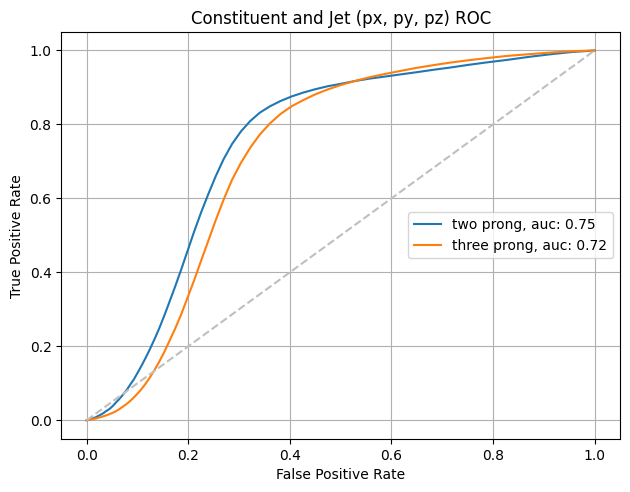

In [17]:
plot_auc(bkg_losses, [two_signal_losses, three_signal_losses], ['two prong', 'three prong'])

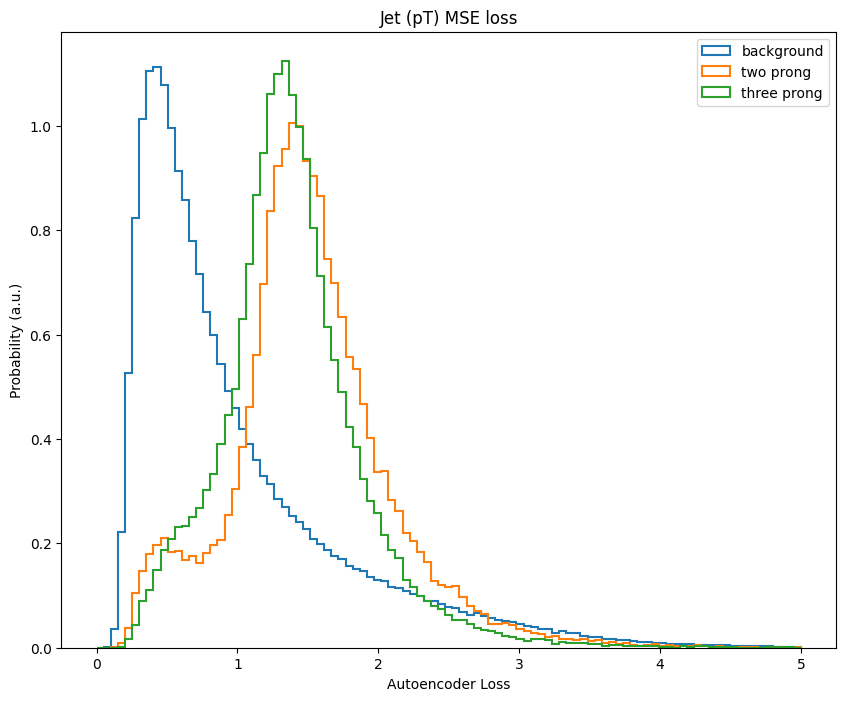

In [11]:
plot_histogram(bkg_losses, [two_signal_losses, three_signal_losses], ['two prong', 'three prong'], bin_size = np.linspace(0, 5, 100))

# Mean and Standard Deviation Computation

In [ ]:
def compute_mean_std_for_loader(loader):

    # collect data in a list
    data_list = [data for data in loader]

    # Stack the data
    all_data = torch.cat(data_list, dim=0)

    # Compute mean and std
    means = torch.mean(all_data, dim=0)
    std_devs = torch.std(all_data, dim=0)

    return means, std_devs

In [ ]:
#means, std_devs = compute_mean_std_for_loader()
#print(means, std_devs)